<a href="https://colab.research.google.com/github/ajaym416/GAN/blob/main/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt


class WGAN():
    def __init__(self
        , input_dim
        , critic_conv_filters
        , critic_conv_kernel_size
        , critic_conv_strides
        , critic_batch_norm_momentum
        , critic_activation
        , critic_dropout_rate
        , critic_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_size
        self.critic_conv_strides = critic_conv_strides
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_activation = critic_activation
        self.critic_dropout_rate = critic_dropout_rate
        self.critic_learning_rate = critic_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser

        self.z_dim = z_dim

        

        self.n_layers_critic = len(critic_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0

    
        self._build_critic()
        self._build_generator()

        self._build_adversarial()

    def wasserstein(self, y_true, y_pred):
        return - K.mean(y_true * y_pred)

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_critic(self):

        ### THE critic
        critic_input = Input(shape=self.input_dim, name='critic_input')

        x = critic_input

        for i in range(self.n_layers_critic):

            x = Conv2D(
                filters = self.critic_conv_filters[i]
                , kernel_size = self.critic_conv_kernel_size[i]
                , strides = self.critic_conv_strides[i]
                , padding = 'same'
                , name = 'critic_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.critic_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.critic_batch_norm_momentum)(x)

            x = self.get_activation(self.critic_activation)(x)

            if self.critic_dropout_rate:
                x = Dropout(rate = self.critic_dropout_rate)(x)

        x = Flatten()(x)

        # x = Dense(512, kernel_initializer = self.weight_init)(x)

        # x = self.get_activation(self.critic_activation)(x)
        
        critic_output = Dense(1, activation=None
        , kernel_initializer = self.weight_init
        )(x)

        self.critic = Model(critic_input, critic_output)



    def _build_generator(self):

        ### THE generator

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size)
        ,kernel_initializer = self.weight_init
        )(x)

        
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

        x = self.get_activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                filters = self.generator_conv_filters[i]
                , kernel_size = self.generator_conv_kernel_size[i]
                , padding = 'same'
                , name = 'generator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
            
            else:
                x = Activation('tanh')(x)


        generator_output = x

        self.generator = Model(generator_input, generator_output)


    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti

    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val


    def _build_adversarial(self):
        
        ### COMPILE critic

        self.critic.compile(
            optimizer=self.get_opti(self.critic_learning_rate) 
            , loss = self.wasserstein
        )
        
        ### COMPILE THE FULL GAN

        self.set_trainable(self.critic, False)

        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.critic(self.generator(model_input))
        self.model = Model(model_input, model_output)
        
        self.model.compile(
            optimizer=self.get_opti(self.generator_learning_rate)
            , loss=self.wasserstein
            )

        self.set_trainable(self.critic, True)



    
    def train_critic(self, x_train, batch_size, clip_threshold, using_generator):

        valid = np.ones((batch_size,1))
        fake = -np.ones((batch_size,1))

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
        
        
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        d_loss_real =   self.critic.train_on_batch(true_imgs, valid)
        d_loss_fake =   self.critic.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        for l in self.critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
            l.set_weights(weights)

        # for l in self.critic.layers:
        
        #     weights = l.get_weights()
        #     if 'batch_normalization' in l.get_config()['name']:
        #         pass
        #         # weights = [np.clip(w, -0.01, 0.01) for w in weights[:2]] + weights[2:]
        #     else:
        #         weights = [np.clip(w, -0.01, 0.01) for w in weights]
            
        #     l.set_weights(weights)

        return [d_loss, d_loss_real, d_loss_fake]

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 10
        , n_critic = 5
        , clip_threshold = 0.01
        , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            for _ in range(n_critic):
                d_loss = self.train_critic(x_train, batch_size, clip_threshold, using_generator)

            g_loss = self.train_generator(batch_size)
               
            # Plot the progress
            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)]  [G loss: %.3f] " % (epoch, d_loss[0], d_loss[1], d_loss[2], g_loss))
            
            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)
            
            self.epoch+=1

    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        #Rescale images 0 - 1

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.critic, to_file=os.path.join(run_folder ,'viz/critic.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



            
    def save(self, folder):

            with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
                pickle.dump([
                    self.input_dim
                    , self.critic_conv_filters
                    , self.critic_conv_kernel_size
                    , self.critic_conv_strides
                    , self.critic_batch_norm_momentum
                    , self.critic_activation
                    , self.critic_dropout_rate
                    , self.critic_learning_rate
                    , self.generator_initial_dense_layer_size
                    , self.generator_upsample
                    , self.generator_conv_filters
                    , self.generator_conv_kernel_size
                    , self.generator_conv_strides
                    , self.generator_batch_norm_momentum
                    , self.generator_activation
                    , self.generator_dropout_rate
                    , self.generator_learning_rate
                    , self.optimiser
                    , self.z_dim
                    ], f)

            self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.critic.save(os.path.join(run_folder, 'critic.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

In [ ]:
from tensorflow.keras.datasets import cifar10
def load_cifar(label, num):
    if num == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')

    train_mask = [y[0]==label for y in y_train]
    test_mask = [y[0]==label for y in y_test]

    x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
    y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])

    x_data = (x_data.astype('float32') - 127.5) / 127.5
 
    return (x_data, y_data)

In [ ]:
# run params
SECTION = 'gan'
RUN_ID = '0002'
DATA_NAME = 'horses'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

os.makedirs(RUN_FOLDER,exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'viz'),exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'images'),exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'weights'),exist_ok=True)

mode =  'build' #'load' #

In [ ]:
if DATA_NAME == 'cars':
    label = 1
elif DATA_NAME == 'horses':
    label = 7
(x_train, y_train) = load_cifar(label, 10)

170508288/170498071 [==============================] - 2s 0us/step


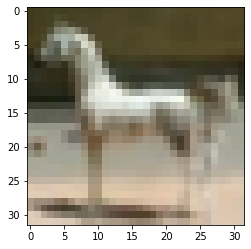

In [ ]:
plt.imshow((x_train[150,:,:,:]+1)/2)


In [ ]:
if mode == 'build':

    gan = WGAN(input_dim = (32,32,3)
            , critic_conv_filters = [32,64,128,128]
            , critic_conv_kernel_size = [5,5,5,5]
            , critic_conv_strides = [2,2,2,1]
            , critic_batch_norm_momentum = None
            , critic_activation = 'leaky_relu'
            , critic_dropout_rate = None
            , critic_learning_rate = 0.00005
            , generator_initial_dense_layer_size = (4, 4, 128)
            , generator_upsample = [2,2, 2,1]
            , generator_conv_filters = [128,64,32,3]
            , generator_conv_kernel_size = [5,5,5,5]
            , generator_conv_strides = [1,1, 1,1]
            , generator_batch_norm_momentum = 0.8
            , generator_activation = 'leaky_relu'
            , generator_dropout_rate = None
            , generator_learning_rate = 0.00005
            , optimiser = 'rmsprop'
            , z_dim = 100
            )
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [ ]:
gan.critic.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 critic_conv_0 (Conv2D)      (None, 16, 16, 32)        2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 32)        0         
                                                                 
 critic_conv_1 (Conv2D)      (None, 8, 8, 64)          51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 critic_conv_2 (Conv2D)      (None, 4, 4, 128)         204928    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0     

In [ ]:
gan.generator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 2048)              206848    
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 128)        0   

In [ ]:
BATCH_SIZE = 1024
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 20
N_CRITIC = 5
CLIP_THRESHOLD = 0.01

In [ ]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

2700 [D loss: (0.076)(R -0.117, F 0.268)]  [G loss: -0.205] 
2701 [D loss: (0.084)(R -0.074, F 0.242)]  [G loss: -0.181] 
2702 [D loss: (0.044)(R -0.074, F 0.163)]  [G loss: -0.117] 
2703 [D loss: (0.017)(R -0.059, F 0.094)]  [G loss: -0.033] 
2704 [D loss: (-0.018)(R -0.053, F 0.017)]  [G loss: 0.044] 
2705 [D loss: (-0.041)(R -0.037, F -0.045)]  [G loss: 0.121] 
2706 [D loss: (-0.070)(R -0.017, F -0.123)]  [G loss: 0.209] 
2707 [D loss: (-0.105)(R -0.038, F -0.172)]  [G loss: 0.272] 
2708 [D loss: (-0.130)(R -0.063, F -0.196)]  [G loss: 0.328] 
2709 [D loss: (-0.133)(R -0.080, F -0.186)]  [G loss: 0.329] 
2710 [D loss: (-0.127)(R -0.105, F -0.148)]  [G loss: 0.296] 
2711 [D loss: (-0.129)(R -0.122, F -0.137)]  [G loss: 0.300] 
2712 [D loss: (-0.149)(R -0.113, F -0.184)]  [G loss: 0.338] 
2713 [D loss: (-0.215)(R -0.162, F -0.267)]  [G loss: 0.377] 
2714 [D loss: (-0.213)(R -0.161, F -0.264)]  [G loss: 0.338] 
2715 [D loss: (-0.232)(R -0.189, F -0.274)]  [G loss: 0.304] 
2716 [D loss:

In [ ]:
gan.sample_images(RUN_FOLDER)

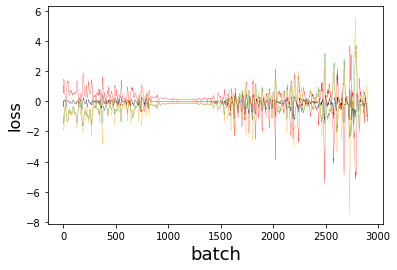

In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
true_imgs = (x_train[idx] + 1) *0.5

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt], cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
plt.close()


In [ ]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.z_dim))
gen_imgs = gan.generator.predict(noise)

#Rescale images 0 - 1

gen_imgs = 0.5 * (gen_imgs + 1)
# gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
plt.close()


fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = compare_images(gen_imgs[cnt, :,:,:], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
plt.close()

In [ ]:
import shutil
shutil.make_archive("/content/run/gan","zip","/content/run","gan")

'/content/run/gan.zip'

In [ ]:
from google.colab import files
files.download("/content/run/gan.zip")

In [ ]:
!cp /content/run/gan.zip /content/drive/MyDrive/gan

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "/content/run/gan/0002_horses/images/sample_*.png"
fp_out = "/content/run/image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)
